In [1]:
%run "../../shared/utilz_text_proc.ipynb"

# 1. LSTM for TimeSeries Data

In [2]:
fpath_tseries_csv = "../../datasets/time_series_covid_19_confirmed.csv"

In [3]:
df = pd.read_csv( fpath_tseries_csv )
df.head(3).T
df.describe()
df.columns

# list(df.columns[4:]) 

,0,1,2
Province/State,NaN,NaN,NaN
Country/Region,Afghanistan,Albania,Algeria
Lat,33,41.1533,28.0339
Long,65,20.1683,1.6596
1/22/20,0,0,0
...,...,...,...
5/17/20,6664,946,7019
5/18/20,7072,948,7201
5/19/20,7653,949,7377
5/20/20,8145,964,7542


,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,...,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02,2.660000e+02
mean,21.148043,22.538640,2.086466,2.458647,3.537594,5.390977,7.962406,11.003759,20.969925,23.180451,...,1.602161e+04,1.634217e+04,1.669986e+04,1.707649e+04,1.742131e+04,1.772038e+04,1.805242e+04,1.841162e+04,1.878373e+04,1.918205e+04
std,24.909990,70.466256,27.279200,27.377862,34.083035,47.434934,66.289178,89.313757,219.187744,220.524977,...,9.061438e+04,9.206191e+04,9.388872e+04,9.563250e+04,9.732850e+04,9.864373e+04,1.001546e+05,1.016416e+05,1.033030e+05,1.051036e+05
min,-51.796300,-135.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,6.907750,-18.093125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.137500e+02,1.137500e+02,1.152500e+02,1.167500e+02,1.220000e+02,1.222500e+02,1.242500e+02,1.302500e+02,1.322500e+02,1.360000e+02
50%,23.488100,20.972650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.400000e+02,6.450000e+02,6.535000e+02,6.535000e+02,6.590000e+02,6.600000e+02,6.835000e+02,7.095000e+02,7.125000e+02,7.275000e+02
75%,41.143200,77.191525,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.048500e+03,3.126750e+03,3.314750e+03,3.361000e+03,3.419750e+03,3.482750e+03,3.549250e+03,3.597250e+03,3.730750e+03,3.954250e+03
max,71.706900,178.065000,444.000000,444.000000,549.000000,761.000000,1058.000000,1423.000000,3554.000000,3554.000000,...,1.369376e+06,1.390406e+06,1.417774e+06,1.442824e+06,1.467820e+06,1.486757e+06,1.508308e+06,1.528568e+06,1.551853e+06,1.577147e+06


Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/12/20', '5/13/20', '5/14/20', '5/15/20', '5/16/20', '5/17/20',
       '5/18/20', '5/19/20', '5/20/20', '5/21/20'],
      dtype='object', length=125)

In [4]:
## melt columns to rows
df = df.melt( id_vars=["Province/State", "Country/Region", "Lat", "Long"], 
             value_vars= list(df.columns[4:]) ,
             var_name="ReportingDate", 
             value_name="NumberCases")

df.ReportingDate = pd.to_datetime( df.ReportingDate, format="%m/%d/%y" , errors='ignore')
df.NumberCases = pd.to_numeric( df.NumberCases )

df.head(3)

df.describe()

df.dtypes

,Province/State,Country/Region,Lat,Long,ReportingDate,NumberCases
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0


,Lat,Long,NumberCases
count,32186.000000,32186.000000,3.218600e+04
mean,21.148043,22.538640,5.025940e+03
std,24.863509,70.334768,4.479493e+04
min,-51.796300,-135.000000,0.000000e+00
25%,6.877000,-19.020800,0.000000e+00
50%,23.488100,20.972650,2.000000e+01
75%,41.153300,78.000000,4.550000e+02
max,71.706900,178.065000,1.577147e+06


Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
ReportingDate     datetime64[ns]
NumberCases                int64
dtype: object

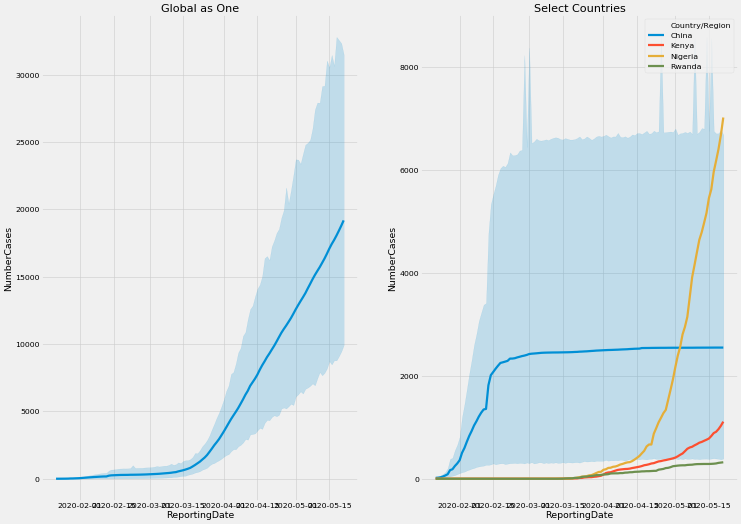

In [5]:
#plt.plot( df.ReportingDate, df.NumberCases , "--g");
nr, nc = 1, 2
plt.subplot(nr, nc, 1)
sns.lineplot(df.ReportingDate, df.NumberCases ); 
plt.title("Global as One");

# df['Country/Region'].unique()
TARGZ = ['Kenya', "Rwanda", "Nigeria","China"] #, "Italy", "US"
plt.subplot(nr, nc, 2)
sns.lineplot(x="ReportingDate", y="NumberCases" , hue="Country/Region", data = df[ df["Country/Region"].isin(TARGZ) ]); 
plt.title("Select Countries"); 

In [6]:
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [7]:
percent_test = 0.2 

test_idz = sorted( list(df.sample(n=int(len(df)*percent_test), random_state=1).index) )
train_idz = sorted( list( df.index[ ~df.index.isin(test_idz) ] ))

print( f"Training set n = {len(train_idz)}" )
print( f"\t{train_idz[:4]}" )
print(f"\nTesting set n = {len(test_idz)}" )
print( f"\t{test_idz[:4]}" )

Training set n = 25749
	[0, 1, 3, 4]

Testing set n = 6437
	[2, 11, 23, 24]


In [8]:
df_test = df.loc[ df.index.isin(test_idz) , ["ReportingDate",'NumberCases'] ]
df_train = df.loc[ df.index.isin(train_idz) , ["ReportingDate",'NumberCases'] ]

df_train = df_train.set_index('ReportingDate')
df_test = df_test.set_index('ReportingDate')

for d in [df_train, df_test]:     
    print(f"\nType: {type(d)}")
    print(f"Size: {len(d)}")
    print(f"mean: { d.mean()}")
    print(f"Top: { d[:3]}")


Type: <class 'pandas.core.frame.DataFrame'>
Size: 25749
mean: NumberCases    4939.004466
dtype: float64
Top:                NumberCases
ReportingDate             
2020-01-22               0
2020-01-22               0
2020-01-22               0

Type: <class 'pandas.core.frame.DataFrame'>
Size: 6437
mean: NumberCases    5373.694734
dtype: float64
Top:                NumberCases
ReportingDate             
2020-01-22               0
2020-01-22               0
2020-01-22               0


In [9]:
scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform( train )
test = scaler.transform( test )


for d in [train, test]:
    print(f"min = {d.min()}, max = {d.max()}, mean = {d.mean()}" )

NameError: name 'train' is not defined

In [ ]:
n_input = 12 # cycles = months 
n_features = 1
tx_generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [ ]:
model = Sequential()
model.add( LSTM(200, activation='relu', input_shape=(n_input, n_features)) )
model.add( Dropout(0.15) ) ##prevent overfitting 
model.add( Dense(1) ) #output p(x)

model.compile( optimizer='adam', loss='mse')

print( len(model.weights  ) ) ## This would be empty if omit input_shape arguement. Else the model gets built continuously as layers get added


In [ ]:
model.fit_generator( tx_generator, epochs=90)

In [ ]:
model

In [ ]:
predicts = []

batch = train[ -n_input:].reshape( (1, n_input, n_features) )

for i in range(n_input):
    predicts.append( model.predict(batch)[0] ) 
    batch = np.append( batch[:, 1:,:], [[predicts[i]]], axis=1) ## use prev month prediction in subsequent predictions
    
df_predicts = pd.DataFrame( scaler.inverse_transform(predicts), index=df_train[ -n_input:].index, columns=["Predicts"]) 

df_predicts.shape

df_predicts.head(3)

#df_predicts.describe()

In [ ]:
#ddf = pd.concat[ df_train, df_test ]
df_output = pd.concat( [df_train, df_predicts], axis=1)

df_output.shape

df_output.head(3)